# Assignment 22.10.2018 # 


2. Project Living skin detection

The task is: train a classifier which is able to distinguish between living and dead materials with highest success rate
The used NN should have few most distinctive input features i.e. spectral lines

Steps:

Read all XLS and CSV data files into Python.  
Visualize them and based on your insight suggest / try some decent feature classifiers.  
Select them, trian them and validate them.  
Analyse runtime and memory footprint.  
Argue why your solution is appropriate.  

In [1]:
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy

dataFiles = ["Fleisch", "Holz", "Leder", "Referenz-Haut_6-Klassen", "Stoff"]
dataFiles2016 = ["2016material","2016material-fake","2016skin","Referenz-Haut_6-Klassen"]

dictionary = {}

for dataType in dataFiles:
    dictionary[dataType] = {}
    with open("Archiv\\" + dataType + '.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter=';')
        for row in csv_reader:
            for key, value in row.items():
                if key in dictionary[dataType]:
                    dictionary[dataType][key].append(float(value.replace(',','.')))
                else:
                    dictionary[dataType][key] = [float(value.replace(',','.'))]

# Output looks pretty cool (sadly, it's useless)
for dataType in dictionary: 
    plot_array = []
    for key, value in dictionary[dataType].items():
        if key == "nm":
            continue
        plot_array.extend([dictionary[dataType]["nm"],value])
    plt.title = dataType
    plt.plot(plot_array)
    plt.show()

In [53]:
# Get variance of data

# New data dict: DataType {NM { {measurement {value }}}}
new_data_dict = {}
# Stores variance: DataType {specific dataType {variance }}
variance = {}
for dataType in dictionary:
    new_data_dict[dataType] = {}
    variance[dataType] = {}
    for i in range(0, len(dictionary[dataType]["nm"])):
        data_dict = {}
        for key, value in dictionary[dataType].items():
            if key == "nm":
                continue
            data_dict[key] = value[i]
        new_data_dict[dataType][dictionary[dataType]["nm"][i]] = data_dict
        
        variance_array = list(data_dict.values())
        variance[dataType][dictionary[dataType]["nm"][i]] = numpy.var(variance_array)

# Amount of inputs needed for the NN
top = 3

for dataType in variance.keys():
    sorted_by_value = sorted(variance[dataType].items(), key=lambda kv : kv[1])
    print (dataType + ": " + str(sorted_by_value[-top:]))

Referenz-Haut_6-Klassen: [(490.0, 157.8692173481306), (480.0, 159.2429268617811), (470.0, 160.46368957286174)]
Holz: [(740.0, 384.5882265691412), (720.0, 386.5633887870793), (730.0, 389.6197942715171)]
Leder: [(850.0, 1060.20768074392), (840.0, 1060.3551699543161), (880.0, 1063.901984167709)]
Fleisch: [(690.0, 150.54354843841264), (680.0, 150.84469343276422), (670.0, 151.26852591644794)]
Stoff: [(620.0, 645.4922313009223), (610.0, 873.4478157694933), (600.0, 929.7861561221637)]


Referenz-Haut_6-Klassen


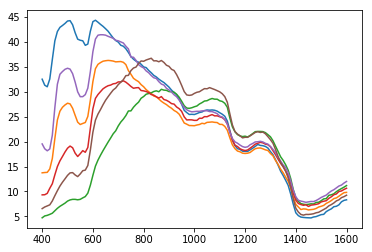

Variance


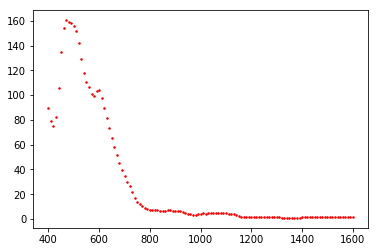

Holz


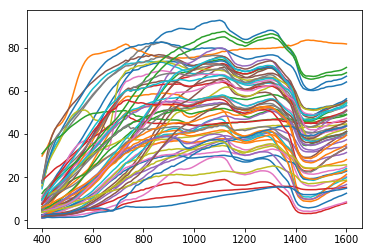

Variance


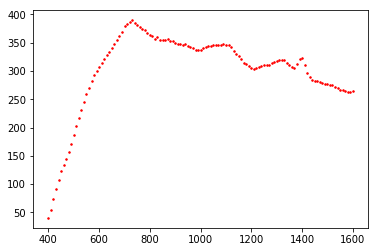

Leder


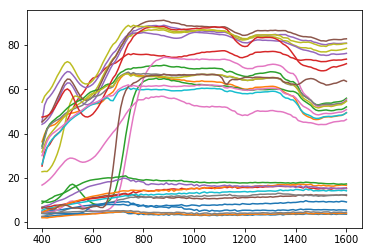

Variance


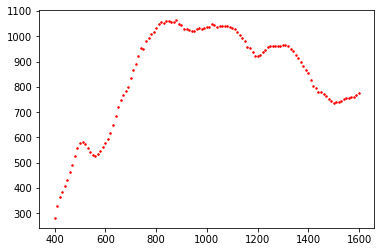

Stoff


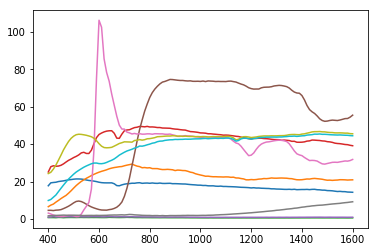

Variance


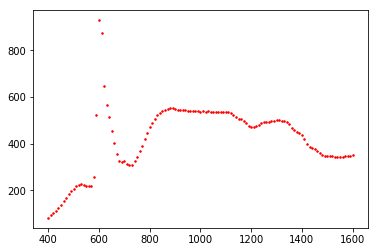

Fleisch


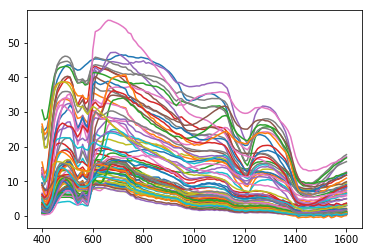

Variance


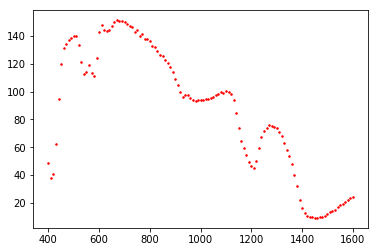

In [3]:
for dataType in dictionary: 
    for key, value in dictionary[dataType].items():
        if key == "nm":
            continue
        plt.plot(dictionary[dataType]["nm"],value)
    print(dataType)
    # Not working :(
    plt.title = dataType
    plt.show()
    print("Variance")
    for key, value in variance[dataType].items():
        plt.plot(key,value, ".r-", linewidth=10, markersize=3)
    plt.show()



Global variance
Global: [(1320.0, 717.7117960057208), (1110.0, 718.9215976853314), (1310.0, 720.4881699571779)]


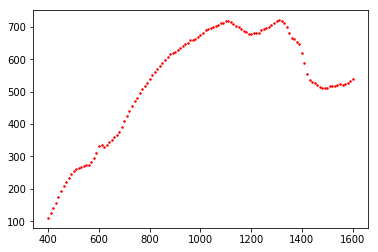

In [9]:
# Variance over all dataTypes
print("Global variance")
global_variance = {}
for dataType in new_data_dict.keys():
    for nm in new_data_dict[dataType].keys():
        variance_array = []
        for dataType2 in new_data_dict.keys():
            variance_array += list(new_data_dict[dataType2][nm].values())
        global_variance[nm] = numpy.var(variance_array)
    break

top = 3

sorted_by_value = sorted(global_variance.items(), key=lambda kv : kv[1])
print ("Global: " + str(sorted_by_value[-top:]))
for key,value in global_variance.items():
    plt.plot(key,value, ".r-", linewidth=10, markersize=3)
plt.show()

# Get list of top nm
top_nm = []
for item in sorted_by_value[-top:]:
    top_nm.append(item[0])

Normalisation
1320.0 before:
31.448160109438366


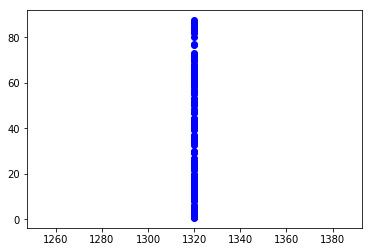

1320.0 after:
2.569194072804882e-15


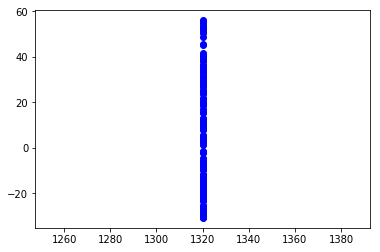

1110.0 before:
34.37886420116122


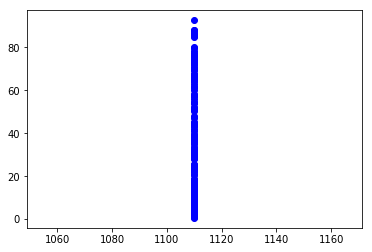

1110.0 after:
-6.422985182012205e-15


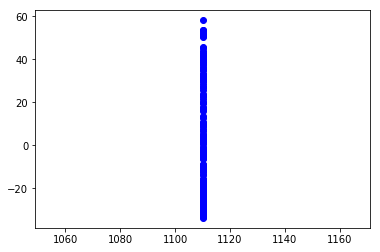

1310.0 before:
31.845575408140267


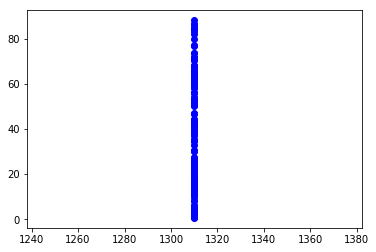

1310.0 after:
-2.569194072804882e-15


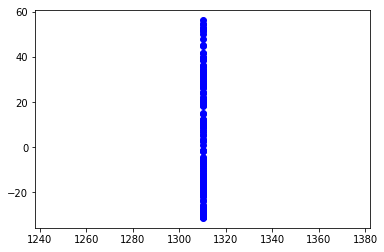

In [50]:
# Center data
print("Normalisation")

normalised_value_dict = {}

# Values
for nm in top_nm:
    value_list = []
    for dataType in new_data_dict:
        for data in new_data_dict[dataType][nm].values():
            value_list.append(data)
            # Display data before
            plt.plot(nm, data, "bo")
    # Get average of all measurements for a specific nm
    average = numpy.average(value_list)
    print(str(nm) + " before:")
    print(average)
    # Show data
    plt.show()
    # Normalise data
    old_variance = []
    for dataType in new_data_dict:
        if dataType not in normalised_value_dict:
            normalised_value_dict[dataType] = {}
        normalised_value_dict[dataType][nm] = {}
        for key, data in new_data_dict[dataType][nm].items():
            new_data = data - 1 * average
            normalised_value_dict[dataType][nm][key] = new_data
            # Display data before
            plt.plot(nm, new_data, "bo") 
            old_variance.append(new_data)
    print(str(nm) + " after:")
    print(numpy.average(old_variance))
    # Show data
    plt.show()
    
    
# normalised_value_dict {dataType {nm {data_spec {value }}}}